<a href="https://colab.research.google.com/github/jkranyak/birdscompetitionkaggle/blob/main/notebooka3489e63aa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'birdclef-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F70203%2F8068726%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T234502Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D46e0e22533c4fcd389c01d0e4a59680f0195c48981d89b38fbcc56169788c4e2ec0cd598173d4b060798187fc098d9ae8be44f928e19332fd7a04dd9291b7cd5812e6ccb7a55cde8fb478dd218fbb7838d1668800383c690cadf71fdb848aef8fc877fe66aa901c88f53b367b5159910d89ce41d7d6e5efaa398ab4edb3a3698eb791cf66685b93ce0b06ccbe72381b605d5a1cd8666e4a5b0c3deed470d2e40bcebf7459e89a08001c6c206049a51e26d8448f234521076fa17a96a87092b56e9f57708917dce91638fcc740d304c9522406f9230270c574117522f32a1760132f49b58bdb9ccae232fd02fe940370249bd14d548dc193e0be81f80f0badebf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 23390009647 bytes downloaded
Downloaded and uncompressed: birdclef-2024
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/birdclef-2024/unlabeled_soundscapes/1132784106.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/1058803039.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/2016683373.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/148271793.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/2050892088.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/333096840.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/2093097362.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/1069318518.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/1229853887.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/202720975.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/2133074275.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/211191982.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/2134313903.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/1932516760.ogg
/kaggle/input/birdclef-2024/unlabeled_sound

In [3]:
!pip install librosa soundfile tensorflow scikit-learn numpy pandas matplotlib seaborn tqdm
!pip install audiomentations
!pip install tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 2.0 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, LSTM, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [3]:

# Define output directories
output_directories = ['processed_data', 'models', 'submissions', 'visualizations']
base_working_dir = '/kaggle/working/'

# Creating subdirectories
for directory in output_directories:
    path = os.path.join(base_working_dir, directory)
    os.makedirs(path, exist_ok=True)
    print(f"Created directory: {path}")

# Define base directories for input data
base_input_dir = "/kaggle/input/birdclef-2024"

# Paths for specific data types
train_audio_base_path = os.path.join(base_input_dir, "train_audio")
unlabeled_soundscapes_path = os.path.join(base_input_dir, "unlabeled_soundscapes")
train_metadata_csv_path = os.path.join(base_input_dir, "train_metadata.csv")
taxonomy_csv_path = os.path.join(base_input_dir, "eBird_Taxonomy_v2021.csv")
sample_submission_csv_path = os.path.join(base_input_dir, "sample_submission.csv")
test_soundscapes_path = os.path.join(base_input_dir, "test_soundscapes")

# Function to list all audio files considering subdirectories
def list_all_audio_files(base_path):
    all_files = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.ogg'):
                all_files.append(os.path.join(root, file))
    return all_files

# Example usage
all_train_audio_files = list_all_audio_files(train_audio_base_path)
print(f"Total audio files found: {len(all_train_audio_files)}")


Created directory: /kaggle/working/processed_data
Created directory: /kaggle/working/models
Created directory: /kaggle/working/submissions
Created directory: /kaggle/working/visualizations
Total audio files found: 24459


### Audio Processing and Spectrogram Generation

In this section, we focus on converting raw audio data into a more visually interpretable form called a spectrogram, which is crucial for our Convolutional Recurrent Neural Network (CRNN) model. Spectrograms provide a 2D representation of the sound where the x-axis represents time, the y-axis represents frequency, and the intensity of colors shows the amplitude of a particular frequency at a particular time.

#### Step-by-step Process:

1. **Audio Loading**: Each audio file is loaded into the memory, which captures the sound's waveform as a time-series data.
2. **Spectrogram Conversion**: The raw audio is then converted into a spectrogram using the Mel scale, which is more aligned with human auditory perception.
3. **Visualization and Saving**: The generated spectrogram is visualized and saved as a PNG file. This image serves as the input to our neural network.

The following visualization is an example of a spectrogram generated from our dataset. This particular audio file represents the call of a bird species recorded in the Western Ghats. By analyzing such images, our model learns to identify patterns specific to different bird calls.





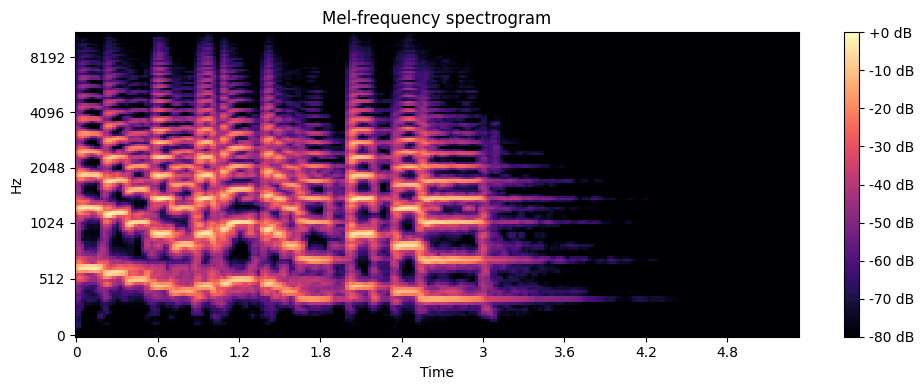

In [4]:
# Example of generating a spectrogram
import librosa.display
import matplotlib.pyplot as plt

# Load an example audio file
y, sr = librosa.load(librosa.ex('trumpet'))

# Create a Mel-spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.power_to_db(S, ref=np.max)

# Plot the Mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

<ipython-input-5-9eb84de97d6e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata.loc[:, 'audio_path'] = filtered_metadata.apply(lambda row: create_audio_path(row, base_audio_dir), axis=1)
<ipython-input-5-9eb84de97d6e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata.loc[:, 'exists'] = filtered_metadata['audio_path'].apply(os.path.exists)
  1%|          | 28/2399 [00:20<33:40,  1.17it/s]

KeyboardInterrupt: 

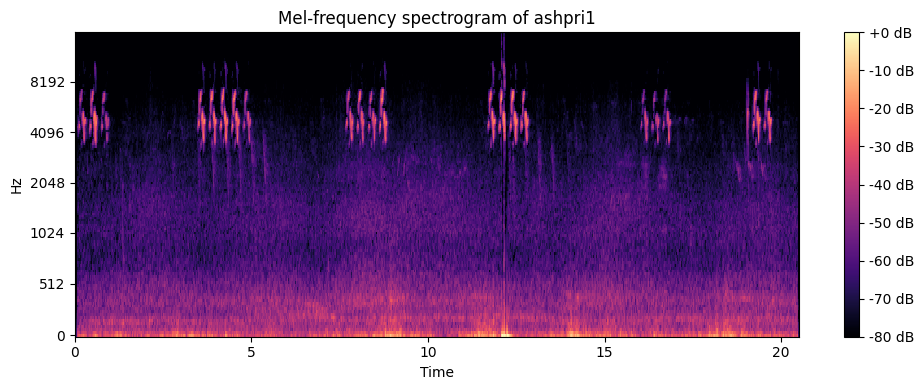

In [5]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
# Load metadata
metadata_path = '/kaggle/input/birdclef-2024/train_metadata.csv'
metadata = pd.read_csv(metadata_path)
filtered_metadata = metadata[metadata['latitude'].between(8, 21) & metadata['longitude'].between(72, 78)]

# Define the base directory for train audio
base_audio_dir = '/kaggle/input/birdclef-2024/train_audio'
output_base_dir = '/kaggle/working/processed_data'

# Define the function to create audio paths
def create_audio_path(row, base_dir):
    """Constructs full path to an audio file based on the metadata."""
    return os.path.join(base_dir, row['filename'])

# Check and construct full audio paths, verify existence
filtered_metadata.loc[:, 'audio_path'] = filtered_metadata.apply(lambda row: create_audio_path(row, base_audio_dir), axis=1)
filtered_metadata.loc[:, 'exists'] = filtered_metadata['audio_path'].apply(os.path.exists)

# Filter out non-existing files
valid_files_metadata = filtered_metadata[filtered_metadata['exists']]

# Create spectrograms
def time_shift_audio(data, sr, shift_max_ratio=0.2):
    shift_amount = int(np.random.uniform(-shift_max_ratio, shift_max_ratio) * len(data))
    return np.roll(data, shift_amount)

def pitch_shift_audio(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(data, sr, n_steps)

def process_and_save_spectrogram(row, apply_time_shift=False, apply_pitch_shift=False):
    """Process each audio file, apply optional augmentations, generate spectrogram, and save in designated folder."""
    audio_path = row['audio_path']
    primary_label = row['primary_label'] if pd.notna(row['primary_label']) else 'unknown'
    output_dir = os.path.join(output_base_dir, primary_label)
    os.makedirs(output_dir, exist_ok=True)

    try:
        y, sr = librosa.load(audio_path, sr=None)
        if apply_time_shift:
            y = time_shift_audio(y, sr)
        if apply_pitch_shift:
            y = pitch_shift_audio(y, sr)

        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_DB = librosa.power_to_db(S, ref=np.max)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel-frequency spectrogram of {primary_label}')
        plt.tight_layout()

        save_path = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(audio_path))[0]}_spectrogram.png")
        plt.savefig(save_path)
        plt.close()
        return f"Saved: {save_path}"
    except Exception as e:
        return f"Failed to process {audio_path}: {str(e)}"


# Process and save spectrograms
results = [process_and_save_spectrogram(row) for _, row in tqdm(valid_files_metadata.iterrows(), total=valid_files_metadata.shape[0])]

# Print the results
for result in results[:10]:  # Just print the first 10 results
    print(result)

### Model Design: Convolutional Recurrent Neural Network (CRNN)

The CRNN model combines the spatial feature extraction capabilities of Convolutional Neural Networks (CNNs) with the sequence modeling prowess of Recurrent Neural Networks (RNNs), making it ideal for audio classification tasks like bird call identification.

#### Architecture Overview:

- **Convolutional Layers**: These layers extract a hierarchy of high-level features from the spectrogram images.
- **Recurrent Layer**: An LSTM layer processes the sequence of features extracted by the CNN to capture temporal dependencies.
- **Output Layer**: Outputs the probability distribution across all bird species, predicting the likelihood of each species being present in the audio clip.

#### Why CRNN?

- **Spatial Feature Extraction**: The CNN layers effectively identify spatial features in spectrograms, such as shapes and textures associated with various bird sounds.
- **Temporal Sequence Modeling**: The LSTM layer captures the temporal dynamics of bird calls, crucial for distinguishing between similar-sounding bird species.
- **Efficiency**: CRNNs can handle large input sizes and are effective in environments with limited labeled data, which is typical in bird sound classification.

This hybrid model structure leverages the strengths of both CNNs and RNNs, providing a robust framework for our bird species classification task.

The next steps will involve training this model on our processed dataset, evaluating its performance, and refining the approach based on the observed results.


In [6]:
from tqdm import tqdm

# Example of processing and saving spectrograms with time shift augmentation
results = [process_and_save_spectrogram(row, augmentation='time_shift') for _, row in tqdm(valid_files_metadata.iterrows(), total=valid_files_metadata.shape[0])]

# Optionally print the results
for result in results[:10]:  # Just print the first 10 results
    print(result)


  0%|          | 0/2399 [00:00<?, ?it/s]

TypeError: process_and_save_spectrogram() got an unexpected keyword argument 'augmentation'

In [7]:
def create_crnn_model(input_shape, num_classes):
    model = Sequential([
        TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=input_shape),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
        TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
        TimeDistributed(Flatten()),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define model parameters
input_shape = (None, 128, 128, 1)  # Example input shape (time_steps, height, width, channels)
num_classes = 182  # Number of bird species

# Create the CRNN model
model = create_crnn_model(input_shape, num_classes)
model.summary()


  1%|          | 28/2399 [00:32<46:00,  1.16s/it]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 126, 126,    320       
 ributed)                    32)                                 
                                                                 
 time_distributed_1 (TimeDi  (None, None, 126, 126,    128       
 stributed)                  32)                                 
                                                                 
 time_distributed_2 (TimeDi  (None, None, 63, 63, 32   0         
 stributed)                  )                                   
                                                                 
 time_distributed_3 (TimeDi  (None, None, 61, 61, 64   18496     
 stributed)                  )                                   
                                                                 
 time_distributed_4 (TimeDi  (None, None, 61, 61, 64   2

## Data Splitting and Processing Strategy

### Data Splitting
In machine learning, it's crucial to evaluate the model on data that it hasn't seen during training. This ensures that our model's performance is robust and generalizes well to new, unseen data. For this purpose, we split our dataset into three distinct sets:

1. **Training Set**: Used to train the model, adjusting the weights of the network as it learns to classify bird species based on their calls.
2. **Validation Set**: Used to fine-tune model parameters and prevent overfitting. It helps in deciding when to stop training before the model starts to overfit.
3. **Test Set**: Used only for testing the final model to assess its performance. This set is crucial for simulating an unbiased evaluation of the model's performance in the real world.

We allocate 20% of our data to the test set and use 25% of the remaining data as the validation set. This division is achieved using the `train_test_split` function from Scikit-learn, ensuring that each set is a random sample of the whole.

### Iterative Processing
The reason for processing the training, validation, and test datasets separately and iteratively post-splitting, as opposed to setting it up to process all at once, includes:

- **Custom Processing Logic**: Allows for applying potentially different preprocessing or augmentation strategies tailored to each dataset's needs.
- **Memory Efficiency**: Processing large datasets can be memory-intensive. By iterating over smaller subsets (training, validation), we manage system resources more effectively, reducing the risk of overloading the system's memory.
- **Debugging and Validation**: Easier to debug and validate the processing steps when handled separately. If an issue arises, it can be isolated and addressed without reprocessing the entire dataset.


In [8]:
# Split metadata into train, validation, and test sets
train_meta, test_meta = train_test_split(valid_files_metadata, test_size=0.2, random_state=42)  # 20% for testing
train_meta, val_meta = train_test_split(train_meta, test_size=0.25, random_state=42)  # 25% of the remaining 80% for validation

# Process each set separately (example for training set)
#train_results = [process_and_save_spectrogram(row) for _, row in tqdm(train_meta.iterrows(), total=train_meta.shape[0])]


## Model Training and Checkpointing

We train the neural network using the `fit` method, specifying the training and validation datasets. The training process iterates over the dataset in batches for a predefined number of epochs, which we've set to 50. This provides the model sufficient opportunity to learn from the data.

### Checkpointing
To enhance the training process, we utilize the `ModelCheckpoint` callback from TensorFlow. This is crucial for the following reasons:

1. **Model Saving**: Automatically saves the model at the end of each epoch. It only saves the model if the validation loss has decreased, ensuring that we retain the best version of the model.
2. **Training Management**: Prevents loss of a model in case the training process is interrupted.
3. **Performance Monitoring**: Helps in monitoring the model's performance over time, specifically observing the validation loss.

The model checkpoint is saved to the path `/kaggle/working/models/best_model.hdf5`, which is convenient for later access and deployment. The training process's progress is logged verbosely to give insight into the model's learning and performance on unseen validation data.

### Observations:
After training, we can analyze the model's accuracy and loss metrics. The checkpoints allow us to revert to the best model state if later epochs do not show improvement, ensuring that we always have the best-performing model at hand.


In [9]:
# Load the data
(train_data, train_labels), (val_data, val_labels) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
train_data = train_data.reshape(60000, 784)
train_data = train_data.astype('float32') / 255

val_data = val_data.reshape(10000, 784)
val_data = val_data.astype('float32') / 255

# Convert the labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
val_labels = tf.keras.utils.to_categorical(val_labels, 10)

11490434/11490434 [==============================] - 0s 0us/step


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint
checkpoint_path = "/kaggle/working/models/best_model.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
train_data = train_data.reshape((-1, 10, 28, 28, 1))  # Update 10 to your specific time steps
val_data = val_data.reshape((-1, 10, 28, 28, 1))

# Update your model fitting code
history = model.fit(
    train_data, train_labels,
    epochs=50,
    validation_data=(val_data, val_labels),
    callbacks=[checkpoint]
)

ValueError: Data cardinality is ambiguous:
  x sizes: 6000
  y sizes: 60000
Make sure all arrays contain the same number of samples.